In [1]:
import json
import torch
import os
import numpy as np
import pickle
from datetime import datetime
import sys
import math
import random
sys.path.append(r'/home/jupyter/openprotein')

from util import contruct_dataloader_from_disk

torch.manual_seed(8)
np.random.seed(8)

In addition to what is included in the repo, the "data" directory should also include a directory called "casp12-preprocessed". This holds casp12 data that has been preprocessed. See `run_preprocessing.py`. 

In [2]:
DATA_DIRECTORY = "data"

## Model definition

We used a simple transformer encoder architecture. We directly used the output from the transformer encoder as the prediction; however, we think adding an extra layer after this could have helped.

In [3]:
MAX_LEN = 2000  # for positional encoding

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.ninp = ninp
        self.ntoken = ntoken

    def forward(self, src, src_key_padding_mask):
        src = src * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        return output
    
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=MAX_LEN):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)


        offset = 0
        if d_model % 2 != 0:
            d_model += 1
            offset = 1

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        if offset > 0:
            pe = pe[:, :-1]

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Loss function

In [4]:
from util import get_backbone_positions_from_angles, calc_avg_drmsd_over_minibatch

def calc_drmsd_loss(src, tgt, batch_sizes, use_gpu=True):
    """
    src: full ground-truth source sequence
    tgt: full source sequence, with the predictions replacing the masked indices
    """
    pred_positions, _ = get_backbone_positions_from_angles(tgt, batch_sizes, use_gpu=use_gpu)
    gt_positions, _ = get_backbone_positions_from_angles(src, batch_sizes, use_gpu=use_gpu)
    return calc_avg_drmsd_over_minibatch(pred_positions, gt_positions, batch_sizes)

## Config

Load the config from a JSON or define it here.

In [5]:
# example config:
with open("configs/" + "config.json") as f:
    config = json.load(f)
    
display(config)

{'model_params': {'nhid': 128, 'nlayers': 3, 'nhead': 3, 'dropout': 0.4},
 'training_params': {'N_EPOCHS': 20,
  'USE_GPU': True,
  'PRINT_EVERY_BATCHES': 40,
  'lr': 0.0001,
  'BATCH_SIZE': 16,
  'LOG_TRAIN_LOSS_EVERY_BATCHES': 100,
  'TRIG_EXPAND': True},
 'data': {'training_file': 'training_70.hdf5',
  'train_val_split': 'train_val_split_70_15pct.pkl'},
 'masking_scheme': {'restrict_to_L': True,
  'max_segment_ratio_of_total': 0.15,
  'mask_all_segments': True,
  'total_max_masked': 0.3}}

In [6]:
# an annotated example of a config:
{
    'model_params': {  # these are passed directly to the model as arguments
        'nhid': 128,
        'nlayers': 3,
        'nhead': 3,
        'dropout': 0.4
    },
    'training_params': {  # for the training loop, mostly self-explanatory
        'N_EPOCHS': 20,
        'USE_GPU': True,
        'PRINT_EVERY_BATCHES': 40,  # printing intermediate progress
        'lr': 0.0001,
        'BATCH_SIZE': 16,
        'LOG_TRAIN_LOSS_EVERY_BATCHES': 100,
        'TRIG_EXPAND': True  # if True, expand each input angle to (cos(x), sin(x)); else, use the original angle in radians
    },
    'data': {
        'training_file': 'training_70.hdf5', 
        'train_val_split': 'train_val_split_70_15pct.pkl'  # indices to divide the training data into train and val
    },
    'masking_scheme': {  # defines how the input will be masked during training. See below for a detailed explanation of masking schemes.
        'restrict_to_L': True,
        'max_segment_ratio_of_total': 0.15,
        'mask_all_segments': True,
        'total_max_masked': 0.3
    }
}

{'model_params': {'nhid': 128, 'nlayers': 3, 'nhead': 3, 'dropout': 0.4},
 'training_params': {'N_EPOCHS': 20,
  'USE_GPU': True,
  'PRINT_EVERY_BATCHES': 40,
  'lr': 0.0001,
  'BATCH_SIZE': 16,
  'LOG_TRAIN_LOSS_EVERY_BATCHES': 100,
  'TRIG_EXPAND': True},
 'data': {'training_file': 'training_70.hdf5',
  'train_val_split': 'train_val_split_70_15pct.pkl'},
 'masking_scheme': {'restrict_to_L': True,
  'max_segment_ratio_of_total': 0.15,
  'mask_all_segments': True,
  'total_max_masked': 0.3}}

## Masking

We used a few different masking configurations. Masking schemes are determined from the config: config["masking_scheme"].

1) Mask all loops (L) that do not individually exceed a threshold length compared to the total protein's length.

* e.g. Find all loops that are less than 15\% of the total protein's length, and mask all of them. Example:
```
"masking_scheme": {
    "restrict_to_L": true,
    "max_segment_ratio_of_total": 0.15,  <-- each Loop does not exceed this ratio of the total protein's length
    "mask_all_segments": true,
    "total_max_masked": null
}
```

* Optionally: Instead of masking all of the loops, mask as many as possible without exceeding some limit. That way, the total masked AAs will never exceed a certain length of the protein. Example:
```
"masking_scheme": {
    "restrict_to_L": true,
    "max_segment_ratio_of_total": 0.15,
    "mask_all_segments": true,
    "total_max_masked": 0.5   <-- the sequence is never masked more than this ratio
}
```

2) Mask a random loop (L) of a length that is within a threshold of the protein's total length.

* Example:
```
"masking_scheme": {
    "restrict_to_L": true,
    "max_segment_ratio_of_total": 0.15,
    "mask_all_segments": false
}
```

3) Mask a random continuous segment of a length that is exactly a certain ratio of the protein's total length.

* Example:
```
"masking_scheme": {
    "restrict_to_L": false,
    "max_segment_ratio_of_total": 0.15
}
```

For configurations that required identifying all loops in a protein that do not exceed a certain length threshold, we use the following function:

In [7]:
def get_loops_from_sequence(secondary, max_length=2000):
    """
    Get all distinct loops ('L') in a secondary sequence
    that are no more than max_length.
    Returns a list of lists of ints, corresponding to indices
    in the secondary sequence.
    """

    LOOP_ID = 0  # 'L' maps to this

    all_loops = []
    running_loop = []
    for i in range(1, secondary.size(0)):
        prev = secondary[i-1]
        cur = secondary[i]

        if i == 1:
            # if first item is a loop, begin a running loop
            if secondary[0] == LOOP_ID:
                running_loop = [0]
        if cur == LOOP_ID and prev == LOOP_ID:
            # continue the current loop
            running_loop.append(i)
        elif cur == LOOP_ID:
            # starting a new loop
            running_loop = [i]
        elif prev == LOOP_ID:
            # end the running loop
            if len(running_loop) <= max_length:
                all_loops.append(running_loop)
            running_loop = []
      
    if len(running_loop) > 0 and len(running_loop) <= max_length:
        all_loops.append(running_loop)
    return all_loops

In [8]:
# For debugging, this conditional statement prints outs the masking scheme that
# was loaded from the config file.

if config["masking_scheme"]["restrict_to_L"]:
    if config["masking_scheme"]["mask_all_segments"]:
        if config["masking_scheme"]["total_max_masked"] is not None:
            print(f"Mask all loops (L) up to {config['masking_scheme']['max_segment_ratio_of_total']} "
                  f"of total protein length, but no more then {config['masking_scheme']['total_max_masked']} "
                  "of the total protein is masked.")
        else:
            print(f"Mask all loops (L) up to {config['masking_scheme']['max_segment_ratio_of_total']} "
                  "of total protein length.")

    else:
        print(f"Mask a single loop (L) that is up to {config['masking_scheme']['max_segment_ratio_of_total']} "
              "of the total protein length.")
        
else:
    print(f"Mask a single continuous segment that is up to {config['masking_scheme']['max_segment_ratio_of_total']} "
          "of the total protein length.")

Mask all loops (L) up to 0.15 of total protein length, but no more then 0.3 of the total protein is masked.


## Training loop definition

In [9]:
def run_epoch(model, optimizer, data_loader, is_train=True):
    """
    Run a training or validation loop for one epoch.
    
    If is_train=True, then the model is set to training mode and
    backprops the loss. Else, the model is used for evaluation.
    
    Returns a list of the loss from each batch.
    """

    epoch_loss = []
    running_loss_printing = []
    
    if is_train:
        model.train()
    else:
        model.eval()
        
    with torch.set_grad_enabled(is_train):
        for b, x in enumerate(data_loader):
            _, _, _, angle, _, secondary = x

            padded_angles = []
            masks = []
            original_lengths = []
            
            # handle batches with incompatible data
            if any(torch.isnan(a).sum() > 0 for a in angle):
                print(f"Skipping batch {b} because of NaN angles.")
                continue
            
            if any(s is None for s in secondary):
                print(f"Skipping batch {b} because of missing secondary data.")
                continue
                
            if any((s == 0).sum() == s.size(0) for s in secondary):
                print(f"Skipping batch {b} because a protein is all 'L'.")  
                continue
                
            max_len = angle[0].size(0)  # get max sequence length in batch
                
            for a, s in zip(angle, secondary):

                if TRIG_EXPAND:
                    a = torch.cat((a.sin(), a.cos()), axis=1)
                
                # pad each sequence of angles to max length of batch
                a_padded = torch.zeros(max_len, a.size(1))
                a_padded[:a.size(0)] = a
                padded_angles.append(a_padded)  

                # keep original lengths for calc_drmsd_loss
                original_lengths.append(a.size(0))
                
                mask = torch.zeros(max_len).type(torch.BoolTensor)
                mask[a.size(0):] = True  # mask the padding
                
                """
                Masking schemes:
                
                These are determined from the config: config["masking_scheme"].
                
                1) Mask all loops (L) that do not individually exceed a threshold length
                compared to the total protein's length
                
                e.g. Find all loops that are less than 15% of the total protein's length, and
                mask all of them.
                
                "masking_scheme": {
                    "restrict_to_L": true,
                    "max_segment_ratio_of_total": 0.15,  <-- each Loop does not exceed this ratio of the total protein's length
                    "mask_all_segments": true,
                    "total_max_masked": null
                }
                
                Optionally: Instead of masking all of the loops, mask as many as possible without
                exceeding some limit. That way, the total masked AAs will never exceed a certain
                length of the protein.
                
                "masking_scheme": {
                    "restrict_to_L": true,
                    "max_segment_ratio_of_total": 0.15,
                    "mask_all_segments": true,
                    "total_max_masked": 0.5   <-- the sequence is never masked more than this ratio
                }
                
                2) Mask a random loop (L) of a length that is within a threshold of the protein's
                total length.
                
                "masking_scheme": {
                    "restrict_to_L": true,
                    "max_segment_ratio_of_total": 0.15,
                    "mask_all_segments": false
                }
                
                3) Mask a random continuous segment of a length that is exactly a certain ratio
                of the protein's total length.
                
                "masking_scheme": {
                    "restrict_to_L": false,
                    "max_segment_ratio_of_total": 0.15
                }

                """
                
                # masking for pretext task
                if config["masking_scheme"]["restrict_to_L"]:
                    loops = get_loops_from_sequence(
                        s,
                        max_length=math.floor(s.size(0) * config["masking_scheme"]["max_segment_ratio_of_total"]))
                    if config["masking_scheme"]["mask_all_segments"]:
                        if config["masking_scheme"]["total_max_masked"] is not None:
                            # Mask ALL segments that are up to 'max_segment_ratio_of_total'
                            # of total protein length, but stop before more then 'total_max_masked'
                            # of the total protein is masked
                            max_length_to_mask = math.floor(a.size(0) * config["masking_scheme"]["total_max_masked"])
                            for loop in loops:
                                max_length_to_mask -= len(loop)
                                if max_length_to_mask >= 0:
                                    mask[loop] = True
                                else:
                                    break
                        else:
                            # Mask ALL segments that are up to 'max_segment_ratio_of_total'
                            # of total protein length
                            for loop in loops:
                                mask[loop] = True

                    else:
                        # Mask only 1 segment
                        random_loop_idx = torch.randint(len(loops), (1,))[0]
                        loop = loops[random_loop_idx]
                        mask[loop] = True
                else:
                    # Mask 1 segment of length 'max_segment_ratio_of_total'
                    # randomly selected from protein
                    seq_len = math.floor(a.size(0) * config["masking_scheme"]["max_segment_ratio_of_total"])

                    random_start_idx = torch.randint(
                        a.size(0) - seq_len,
                        (1,))[0]

                    mask[random_start_idx:random_start_idx+seq_len] = True
            
                # append to batch list of masks
                masks.append(mask)

            stacked_angles = torch.stack(padded_angles, dim=1)
            src_key_padding_mask = torch.stack(masks, dim=0)
            
            if USE_GPU:
                stacked_angles = stacked_angles.cuda()
                src_key_padding_mask = src_key_padding_mask.cuda()

            if is_train:
                optimizer.zero_grad()
                
            output = model(stacked_angles, src_key_padding_mask)

            predicted_full_sequence = stacked_angles.detach().clone()
            for i in range(output.size(1)):
                for j in range(angle[i].size(0)):
                    if masks[i][j]:
                        predicted_full_sequence[j, i, :] = output[j, i, :]

                        
            if TRIG_EXPAND:
                predicted_full_sequence = torch.atan2(predicted_full_sequence[:, :, :3], predicted_full_sequence[:, :, 3:])
                stacked_angles = torch.atan2(stacked_angles[:, :, :3], stacked_angles[:, :, 3:])
                        
            loss = calc_drmsd_loss(stacked_angles, predicted_full_sequence, original_lengths, use_gpu=USE_GPU)
            
            if np.isnan(loss.item()):
                print(f"Batch {b}: Loss is NaN")
                import pdb; pdb.set_trace()
                continue
            
            running_loss_printing.append(loss.item())
            epoch_loss.append(loss.item())
            
            if ((b + 1) % PRINT_EVERY_BATCHES == 0):
                print(f"After {b + 1}/{len(data_loader)} batches, avg. loss since last print: {np.mean(running_loss_printing):.5} ({datetime.now()})")
                running_loss_printing = []    
            
            if is_train:
                loss.backward()
                optimizer.step()
                
    return epoch_loss

## Loading data

Rather than using the train/val/test splits, we randomly divided the original train split into new train and validation splits (70:30), and used the original validation split as the test set. We did this because we did not have secondary data for the original test split. Although it's preferable to use the original data splits, we think the model still should have been able to learn using our splits.

In [10]:
## load secondary data
with open(os.path.join(DATA_DIRECTORY, "full_protein_dssp_annotations.json")) as f:
    secondary_data = json.load(f)
    
with open(os.path.join(DATA_DIRECTORY, "single_domain_dssp_annotations.json")) as f:
    secondary_data.update(json.load(f))

## load train/val split from pickle
train_val_split = config["data"]["train_val_split"]
train_idx, val_idx = pickle.load(open(os.path.join(DATA_DIRECTORY, train_val_split), "rb"))
test_idx = pickle.load(open(os.path.join(DATA_DIRECTORY, "test_split.pkl"), "rb"))

## prepare data loaders
train_protein_dataloader = contruct_dataloader_from_disk(
    os.path.join(DATA_DIRECTORY, 'casp12-preprocessed', config["data"]["training_file"]),
    config["training_params"]["BATCH_SIZE"],
    secondary_data,
    train_idx)
val_protein_dataloader = contruct_dataloader_from_disk(
    os.path.join(DATA_DIRECTORY, 'casp12-preprocessed', config["data"]["training_file"]),
    config["training_params"]["BATCH_SIZE"],
    secondary_data,
    val_idx)
test_protein_dataloader = contruct_dataloader_from_disk(
    os.path.join(DATA_DIRECTORY, 'casp12-preprocessed', 'validation.hdf5'),
    config["training_params"]["BATCH_SIZE"],
    secondary_data,
    test_idx)

## Example: Load trained model

Example of loading a trained model, e.g. for analysis or accessing hidden layers

In [11]:
results_dir = "experiment 2020-11-23 194541"  # directory with weights and a results.json file
weights_file = "model state epoch 20.pt"  # which weights to load

# the config from the model is included in results.json under key "config"
with open(os.path.join("results", results_dir, "results.json")) as f:
    results = json.load(f)
    config = results["config"]
    
USE_GPU = config['training_params']['USE_GPU']
TRIG_EXPAND = config['training_params'].get("TRIG_EXPAND", False)
N_INPUT_DIM = 6 if TRIG_EXPAND else 3

model = TransformerModel(
    ntoken=N_INPUT_DIM,
    ninp=N_INPUT_DIM,
    **config['model_params'])

if USE_GPU:
    model.cuda()

model.load_state_dict(torch.load(os.path.join("results", results_dir, weights_file)))

model.eval()

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=3, out_features=3, bias=True)
        )
        (linear1): Linear(in_features=3, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=3, bias=True)
        (norm1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

## Example: Load an experiment

Load results from an experiment

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_experiment_results(results_dir):
    """
    Plot the train, val and test loss per training epoch for an exerpiment.
    
    results_dir: directory with weights and a results.json file
    """

    # the config from the model is included in results.json under key "config"
    with open(os.path.join("results", results_dir, "results.json")) as f:
        results = json.load(f)

    # organize into a dataframe
    train_losses = [None]
    val_losses = [None]
    test_losses = [None]
    for k,v in results.items():
        if k.startswith('epoch'):
            train_losses.append(v['avg_train_loss'])
            val_losses.append(v['avg_val_loss'])
            test_losses.append(v['avg_test_loss'])

    df = pd.DataFrame([train_losses, val_losses, test_losses]).T
    df.columns = ['train', 'val', 'test']

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    df.plot(ax=ax, style='.-')

    plt.title('Loss by training epoch')
    plt.xlabel('Epoch')
    plt.ylabel('dRMSD loss (angstroms)')

    plt.show()
    
    print("Config:")
    print(json.dumps(results['config'], indent=4))

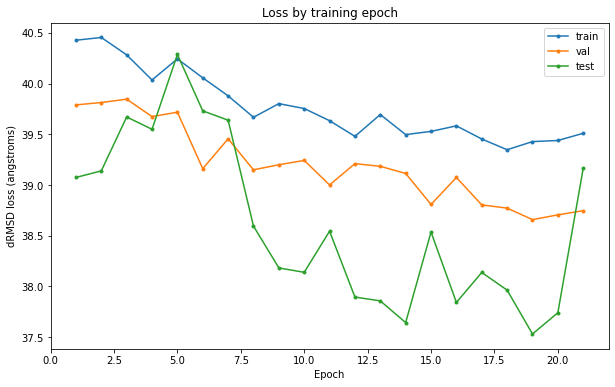

Config:
{
    "model_params": {
        "nhid": 256,
        "nlayers": 1,
        "nhead": 3,
        "dropout": 0.1
    },
    "training_params": {
        "N_EPOCHS": 30,
        "USE_GPU": true,
        "PRINT_EVERY_BATCHES": 10,
        "lr": 0.0001,
        "BATCH_SIZE": 16,
        "LOG_TRAIN_LOSS_EVERY_BATCHES": 100
    },
    "data": {
        "training_file": "training_70.hdf5",
        "train_val_split": "train_val_split_70_15pct.pkl"
    }
}


In [13]:
plot_experiment_results("experiment 2020-11-23 194541")

## Plot results from our experiments

**In this simple task, we masked only one randomly selected loop of length up to 10% of total protein length. The architecture has only 1 layer. It looks like this could be learning.**

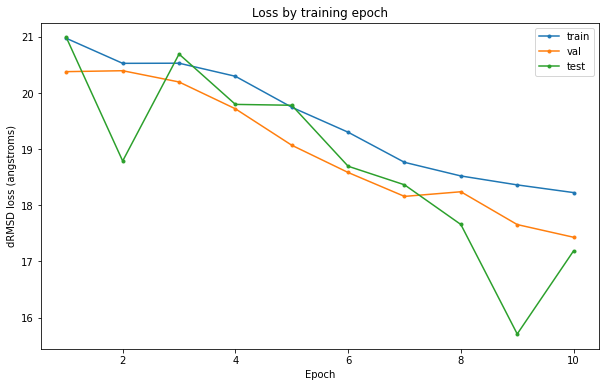

Config:
{
    "model_params": {
        "nhid": 256,
        "nlayers": 1,
        "nhead": 3,
        "dropout": 0.1
    },
    "training_params": {
        "N_EPOCHS": 10,
        "USE_GPU": true,
        "PRINT_EVERY_BATCHES": 10,
        "lr": 0.0001,
        "BATCH_SIZE": 16,
        "LOG_TRAIN_LOSS_EVERY_BATCHES": 100
    },
    "data": {
        "training_file": "training_70.hdf5"
    }
}


In [17]:
plot_experiment_results("experiment 2020-11-20 200736")

**Same architecture, but a much harder task: mask _all_ loops that are each up to _15%_ of the total protein length. Doesn't appear to be learning.**

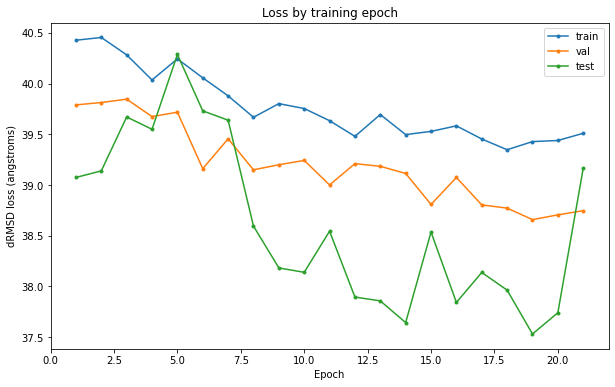

Config:
{
    "model_params": {
        "nhid": 256,
        "nlayers": 1,
        "nhead": 3,
        "dropout": 0.1
    },
    "training_params": {
        "N_EPOCHS": 30,
        "USE_GPU": true,
        "PRINT_EVERY_BATCHES": 10,
        "lr": 0.0001,
        "BATCH_SIZE": 16,
        "LOG_TRAIN_LOSS_EVERY_BATCHES": 100
    },
    "data": {
        "training_file": "training_70.hdf5",
        "train_val_split": "train_val_split_70_15pct.pkl"
    }
}


In [18]:
plot_experiment_results("experiment 2020-11-23 194541")

**Same masking scheme, but with a larger model: 512 hidden dimensions, 6 layers. Still doesn't appear to be learning.**

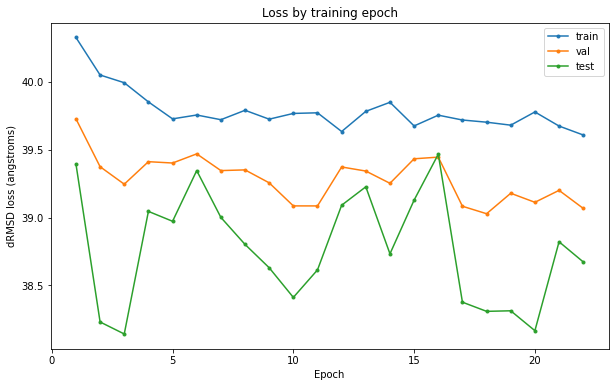

Config:
{
    "model_params": {
        "nhid": 512,
        "nlayers": 6,
        "nhead": 3,
        "dropout": 0.1
    },
    "training_params": {
        "N_EPOCHS": 30,
        "USE_GPU": true,
        "PRINT_EVERY_BATCHES": 10,
        "lr": 0.0001,
        "BATCH_SIZE": 8,
        "LOG_TRAIN_LOSS_EVERY_BATCHES": 100
    },
    "data": {
        "training_file": "training_70.hdf5",
        "train_val_split": "train_val_split_70_15pct.pkl"
    }
}


In [19]:
plot_experiment_results("experiment 2020-11-28 015938")

**Further increasing the size of the model: 12 layers.**

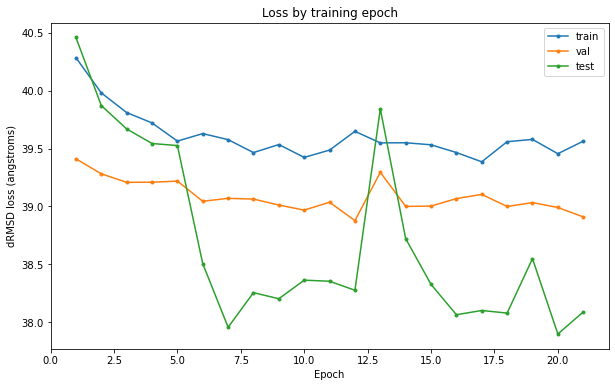

Config:
{
    "model_params": {
        "nhid": 512,
        "nlayers": 12,
        "nhead": 3,
        "dropout": 0.1
    },
    "training_params": {
        "N_EPOCHS": 30,
        "USE_GPU": true,
        "PRINT_EVERY_BATCHES": 40,
        "lr": 0.0001,
        "BATCH_SIZE": 4,
        "LOG_TRAIN_LOSS_EVERY_BATCHES": 100
    },
    "data": {
        "training_file": "training_70.hdf5",
        "train_val_split": "train_val_split_70_15pct.pkl"
    }
}


In [20]:
plot_experiment_results("experiment 2020-12-01 173112")

**Smaller model, with a slightly easier task: mask all loops that are each up to 15% of the total protein length, but the total percent of the protein that is masked does not exceed 30%.**

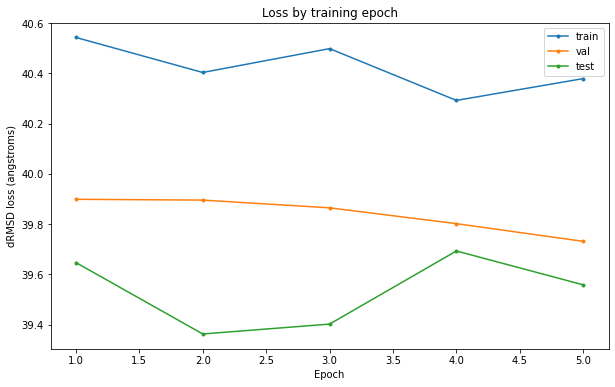

Config:
{
    "model_params": {
        "nhid": 32,
        "nlayers": 3,
        "nhead": 3,
        "dropout": 0.4
    },
    "training_params": {
        "N_EPOCHS": 20,
        "USE_GPU": true,
        "PRINT_EVERY_BATCHES": 40,
        "lr": 0.0001,
        "BATCH_SIZE": 16,
        "LOG_TRAIN_LOSS_EVERY_BATCHES": 100
    },
    "data": {
        "training_file": "training_70.hdf5",
        "train_val_split": "train_val_split_70_15pct.pkl"
    },
    "masking_scheme": {
        "restrict_to_L": true,
        "max_segment_ratio_of_total": 0.15,
        "mask_all_segments": true,
        "total_max_masked": 0.3
    }
}


In [21]:
plot_experiment_results("experiment 2020-12-08 212812")

**Same task, but increase hidden dimensions to 128, and use (cos(x), sin(x)) for each input x.**

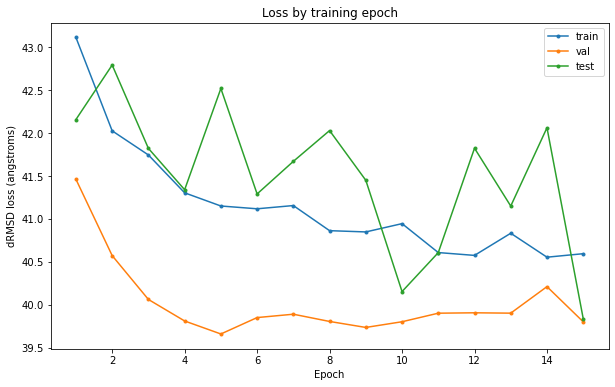

Config:
{
    "model_params": {
        "nhid": 128,
        "nlayers": 3,
        "nhead": 3,
        "dropout": 0.4
    },
    "training_params": {
        "N_EPOCHS": 20,
        "USE_GPU": true,
        "PRINT_EVERY_BATCHES": 40,
        "lr": 0.0001,
        "BATCH_SIZE": 16,
        "LOG_TRAIN_LOSS_EVERY_BATCHES": 100,
        "TRIG_EXPAND": true
    },
    "data": {
        "training_file": "training_70.hdf5",
        "train_val_split": "train_val_split_70_15pct.pkl"
    },
    "masking_scheme": {
        "restrict_to_L": true,
        "max_segment_ratio_of_total": 0.15,
        "mask_all_segments": true,
        "total_max_masked": 0.3
    }
}


In [22]:
plot_experiment_results("experiment 2020-12-09 173212")

**Easier task: mask any random segment that is up to 10% of the total protein. Not restricted to loops. Small size: 32 hidden dims.**

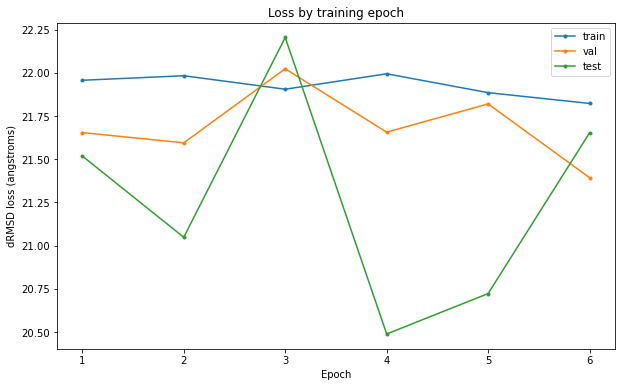

Config:
{
    "model_params": {
        "nhid": 32,
        "nlayers": 3,
        "nhead": 3,
        "dropout": 0.4
    },
    "training_params": {
        "N_EPOCHS": 20,
        "USE_GPU": true,
        "PRINT_EVERY_BATCHES": 40,
        "lr": 0.0001,
        "BATCH_SIZE": 16,
        "LOG_TRAIN_LOSS_EVERY_BATCHES": 100
    },
    "data": {
        "training_file": "training_70.hdf5",
        "train_val_split": "train_val_split_70_15pct.pkl"
    },
    "masking_scheme": {
        "restrict_to_L": false,
        "max_segment_ratio_of_total": 0.1
    }
}


In [23]:
plot_experiment_results("experiment 2020-12-08 225052")

**Much harder task: mask 50% of the protein. The loss increases at first, but the model is actually learning to ignore the input altogether and learn an MLE.**

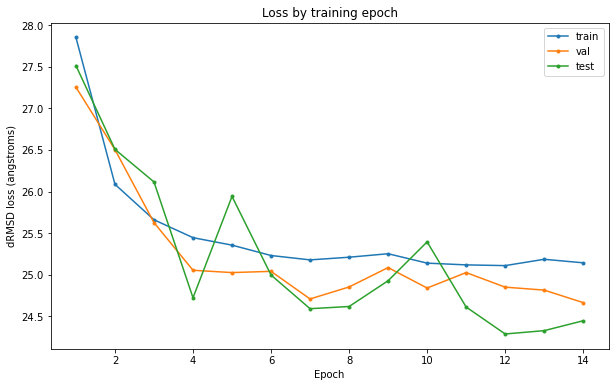

Config:
{
    "model_params": {
        "nhid": 128,
        "nlayers": 3,
        "nhead": 3,
        "dropout": 0.4
    },
    "training_params": {
        "N_EPOCHS": 20,
        "USE_GPU": true,
        "PRINT_EVERY_BATCHES": 40,
        "lr": 0.0001,
        "BATCH_SIZE": 16,
        "LOG_TRAIN_LOSS_EVERY_BATCHES": 100,
        "TRIG_EXPAND": true
    },
    "data": {
        "training_file": "training_70.hdf5",
        "train_val_split": "train_val_split_70_15pct.pkl"
    },
    "masking_scheme": {
        "restrict_to_L": false,
        "max_segment_ratio_of_total": 0.5
    }
}


In [24]:
plot_experiment_results("experiment 2020-12-09 174059")

## Training example

Example of running a training job

In [ ]:
runtime = datetime.now()

## prepare results directory
results_directory = f"results/experiment {runtime:%Y-%m-%d %H%M%S}"
if not os.path.isdir(results_directory):
    os.mkdir(results_directory)

## prepare training
N_EPOCHS = config['training_params']['N_EPOCHS']
USE_GPU = config['training_params']['USE_GPU']
PRINT_EVERY_BATCHES = config['training_params']['PRINT_EVERY_BATCHES']
TRIG_EXPAND = config['training_params'].get("TRIG_EXPAND", False)
N_INPUT_DIM = 6 if TRIG_EXPAND else 3

model = TransformerModel(
    ntoken=N_INPUT_DIM,
    ninp=N_INPUT_DIM,
    **config['model_params'])

if USE_GPU:
    model.cuda()
    
optimizer = torch.optim.Adam(model.parameters(),  lr=config['training_params']['lr'])

## training loop
results = {}  # to hold the results, and ultimately write to a file
results['config'] = config

for i in range(N_EPOCHS):
    print(f"\n\n=== Beginning epoch {i} @ {datetime.now()}")
    print("Training:", datetime.now())
    train_losses = run_epoch(model, optimizer, train_protein_dataloader, is_train=True)

    # write state to file
    torch.save(model.state_dict(), os.path.join(results_directory, f"model state epoch {i}.pt"))
    torch.save(optimizer.state_dict(), os.path.join(results_directory, f"optimizer state epoch {i}.pt"))
    print(f"Saved model and optimizer state dicts to disk in {results_directory}.", datetime.now())

    print("Validation:", datetime.now())
    val_losses = run_epoch(model, optimizer, val_protein_dataloader, is_train=False)

    print("Test:", datetime.now())
    test_losses = run_epoch(model, optimizer, test_protein_dataloader, is_train=False)

    epoch_results = {
        'avg_train_loss': np.mean(train_losses),
        'avg_val_loss': np.mean(val_losses),
        'avg_test_loss': np.mean(test_losses),
        'train_losses': train_losses[::config["training_params"]["LOG_TRAIN_LOSS_EVERY_BATCHES"]]
    }
    results[f'epoch_{i}'] = epoch_results

    output_fname = os.path.join(results_directory, "results.json")
    print(f"Writing epoch results to {output_fname}.")
    with open(output_fname, 'w') as outfile:
        json.dump(results, outfile)